## Agent-Based Model for Belief & Heresy
Agent-Based model based for "believers" based on the model for "the Evolution of Ethnocentrism" from Axelrod and Hammond and the related model for the "Evolution of Ethnic Markers" from McElreath et al. 

"The Evolution of Ethnocentrism", Ross A. Hammond and Robert Axelrod, (2006) Theoretical Population Biology 69: 333-338

"Shared Norms and the Evolution of Ethnic Markers", Richard McElreath, Robert Boyd, and Peter J. Richerson (2003) Current Anthropology, 44(1), 122-129

### The libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

### The agents

In [2]:
STRATEGIES = 4            # overall number of possible strategies
COST = 0.01               # decrease of potential to reproduce by 1%
BENEFIT = 0.03            # increase of potential to reproduce by 3%
REPRODUCTION_RATE = 0.12  # potential to reproduce
DEATH_RATE = 0.05         # chance of dying

class Agent: 
  def __init__(self, trait = 0, strategy_in = 0, strategy_out = 0):
    self.trait = trait               # tag that specifies group membership as one of x predefined values
    self.strategy_in = strategy_in   # cooperate when meeting someone who is in the group
    self.strategy_out = strategy_out # cooperate when meeting someone who is not in the group
    self.ptr = REPRODUCTION_RATE    
    self.mortality = DEATH_RATE
    self.x = 0                       # horizontal location in the environment
    self.y = 0                       # vertical location in the environment
    
  def strategy(self):
    # 3 saints/cooperators who always cooperate (1, 1)
    # 2 believers/patriots who believe in the own group (1, 0)
    # 1 sinners/defectors who never cooperate (0, 1)
    # 0 heretics/traitors who believe in other groups (0, 0)    
    return (self.strategy_in * 2) + self.strategy_out
    
  def reset_ptr(self):
    self.ptr = REPRODUCTION_RATE

  def subtract_ptr(self, amount):
    self.ptr = self.ptr - amount
    if self.ptr < 0: self.ptr = 0

  def add_ptr(self, amount):
    self.ptr = self.ptr + amount

  def reproduce(self):
    value = random.random()
    birth = (value < self.ptr)
    return birth

  def death(self):
    value = random.random()
    death = (value < self.mortality)
    return death

  def select_strategy(self, opponent):
    if opponent.trait == self.trait:
      value = self.strategy_in
    else:
      value = self.strategy_out
    return value

  def interact(self, opponent):
    if (self.select_strategy(opponent) == 1):
      self.subtract_ptr(COST)
      opponent.add_ptr(BENEFIT)
    if (opponent.select_strategy(self) == 1):
      opponent.subtract_ptr(COST)
      self.add_ptr(BENEFIT)
        

Check if the agents work as expected

In [3]:
a = Agent(0, 1, 0)
b = Agent(0, 1, 0)
c = Agent(1, 1, 0)
d = Agent(1, 1, 1)
print("Agent A ptr", a.ptr)
print("Agent B ptr", b.ptr)
a.interact(b)
print("A vs B: both cooperate")
print("Agent A ptr", a.ptr)
print("Agent B ptr", b.ptr)
a.interact(c)
print("A vs C: both do not cooperate")
print("Agent A ptr", a.ptr)
print("Agent C ptr", c.ptr)
a.interact(d)
print("A vs D: A does not cooperate, D does")
print("Agent A ptr", a.ptr)
print("Agent D ptr", d.ptr)

Agent A ptr 0.12
Agent B ptr 0.12
A vs B: both cooperate
Agent A ptr 0.14
Agent B ptr 0.13999999999999999
A vs C: both do not cooperate
Agent A ptr 0.14
Agent C ptr 0.12
A vs D: A does not cooperate, D does
Agent A ptr 0.17
Agent D ptr 0.11


### The agent based model

In [4]:
TRAITS = 8            # number of traits/cultures/ethnic markers
IMMIGRATION_RATE = 1  # probability of adding new members

class AgentBasedModel:
  def __init__(self, size, rate = 0):
    self.grid_size = size
    self.agents = size * size
    self.grid = np.empty(self.agents, dtype=object).reshape((size, size))
    self.data = []
        
  def new_random_agent(self, trait = None):
    if not trait: trait = np.random.randint(1, TRAITS+1)
    strategy_in = np.random.randint(2)
    strategy_out = np.random.randint(2)
    return Agent(trait, strategy_in, strategy_out) 

  def clone_agent(self, agent):
    trait = agent.trait
    strategy_in = agent.strategy_in
    strategy_out = agent.strategy_out
    return Agent(trait, strategy_in, strategy_out) 

  def new_random_position(self):
    i = random.randrange(0, self.agents)
    return (i // self.grid_size), (i % self.grid_size)
        
  def add_agent_to_grid(self, agent, x, y):
    agent.x = x
    agent.y = y
    self.grid[y, x] = agent

  def immigration(self):
    # create new agents at IMMIGRATION_RATE and place at random empty position
    new_immigrant = (random.random() < IMMIGRATION_RATE)
    if new_immigrant:
      x,y = self.new_random_position()
      if not self.grid[y, x]:
         agent = self.new_random_agent()
         self.add_agent_to_grid(agent, x, y)
        
  def grid_position(self, x, y):
    if x >= self.grid_size: x = 0
    if y >= self.grid_size: y = 0
    if x < 0: x = self.grid_size-1
    if y < 0: y = self.grid_size-1
    return x, y

  def neighborhood(self, x, y):
    # Von Neumann neighborhood
    top    = self.grid_position(x, y-1)
    right  = self.grid_position(x+1, y)
    left   = self.grid_position(x-1, y)
    bottom = self.grid_position(x, y+1)
    return [top, right, left, bottom]
     
  def interaction(self): 
    already_played = []
    agents = self.grid.flatten()
    for agent in agents:
      if not agent: continue
      neighborhood = [self.grid[y,x] for x,y in self.neighborhood(agent.x, agent.y)]
      neighbors = [neighbor for neighbor in neighborhood if neighbor and (not neighbor in already_played)] 
      for neighbor in neighbors:
        agent.interact(neighbor)
      already_played.append(agent)

  def reproduction(self):
    agents = self.grid.flatten()
    for agent in agents:
      if agent and agent.reproduce():
        for x,y in self.neighborhood(agent.x, agent.y):
          if not self.grid[y, x]: 
            descendant = self.clone_agent(agent)
            self.add_agent_to_grid(descendant, x, y)
            break

  def death(self):      
    for j in range(self.grid_size):
      for i in range(self.grid_size):
        agent = self.grid[i,j]
        if agent and agent.death():
          self.grid[i,j] = None

  def count_strategy(self, strategy_in, strategy_out):
    count = 0
    all_agents = list(filter(None, self.grid.flatten()))
    for agent in all_agents:
      if (agent.strategy_in == strategy_in) and (agent.strategy_out == strategy_out):
        count += 1
    if len(all_agents) == 0: return 0
    return count / len(all_agents)

  def play(self, timestep):
    self.immigration()
    self.interaction()
    self.reproduction()
    self.death()

  def record_statistics(self, timestep):
    cooperators = self.count_strategy(1, 1) # saints/cooperators who always cooperate
    defectors = self.count_strategy(0, 0)   # sinners/defectors who never cooperate
    patriots = self.count_strategy(1, 0)    # believers/patriots who believe in the own group
    traitors = self.count_strategy(0, 1)    # heretics/traitors who believe in other groups
    self.data.append([timestep, cooperators * 100, defectors * 100, patriots * 100, traitors * 100])
    
  def trait_distribution(self):
    distribution = [agent.trait if agent else 0 for agent in self.grid.flatten()]
    return distribution

  def strategy_grid(self):
    agents = self.grid.flatten()
    traits = np.array([agent.strategy() if agent else 0 for agent in agents])
    return traits.reshape((self.grid_size, self.grid_size))

  def trait_grid(self):
    agents = self.grid.flatten()
    traits = np.array([agent.trait if agent else 0 for agent in agents])
    return traits.reshape((self.grid_size, self.grid_size))

  def run(self, timesteps):
    for t in range(timesteps):
      self.play(t)
      self.record_statistics(t)

Run the model

In [5]:
n = 25
step = 250
model_0 = AgentBasedModel(n)
model_0.run(step)

And display the results using Matplotlib

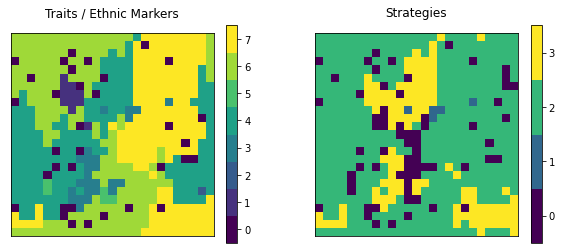

In [6]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

image = model_0.trait_grid()
cmap1 = plt.get_cmap('viridis', TRAITS)
img1 = ax[0].matshow(image, cmap=cmap1, vmin=-0.5, vmax=TRAITS-0.5)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Traits / Ethnic Markers")
fig.colorbar(img1, ax=ax[0], ticks=np.arange(0,8))

image = model_0.strategy_grid()
cmap2 = plt.get_cmap('viridis', STRATEGIES)
img2 = ax[1].matshow(image, cmap=cmap2, vmin=-0.5, vmax=STRATEGIES-0.5)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Strategies")
fig.colorbar(img2, ax=ax[1], ticks=np.arange(0,4))


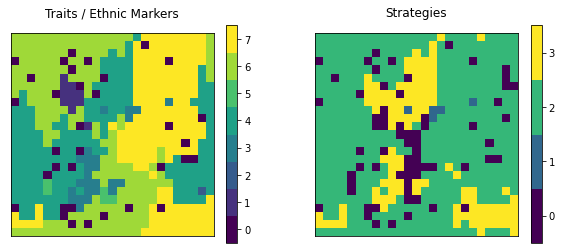

In [7]:
mpl.use('svg')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

image = model_0.trait_grid()
cmap1 = plt.get_cmap('viridis', TRAITS)
img1 = ax[0].matshow(image, cmap=cmap1, vmin=-0.5, vmax=TRAITS-0.5)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Traits / Ethnic Markers")
fig.colorbar(img1, ax=ax[0], ticks=np.arange(0,8))

image = model_0.strategy_grid()
cmap2 = plt.get_cmap('viridis', STRATEGIES)
img2 = ax[1].matshow(image, cmap=cmap2, vmin=-0.5, vmax=STRATEGIES-0.5)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Strategies")
fig.colorbar(img2, ax=ax[1], ticks=np.arange(0,4))

plt.savefig("abm_believers_model.svg", format="svg")

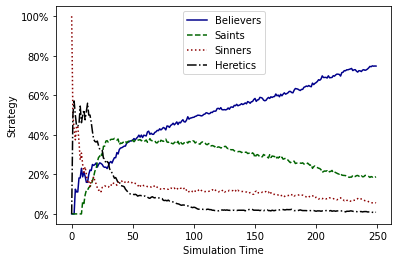

In [8]:
%matplotlib inline
df = pd.DataFrame(model_0.data, columns=['Time', 'Cooperators', 'Defectors', 'Patriots', 'Traitors'])
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Strategy")
plt.xlabel("Simulation Time")
plt.plot(df.Time, df.Patriots, color="DarkBlue", label='Believers', linestyle='solid')
plt.plot(df.Time, df.Cooperators, color="DarkGreen", label='Saints', linestyle='dashed')
plt.plot(df.Time, df.Defectors, color="DarkRed", label='Sinners', linestyle='dotted') 
plt.plot(df.Time, df.Traitors, color="Black", label='Heretics', linestyle='dashdot')
plt.legend()
plt.show()

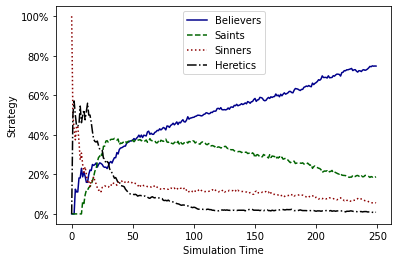

In [9]:
mpl.use('svg')

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Strategy")
plt.xlabel("Simulation Time")
plt.plot(df.Time, df.Patriots, color="DarkBlue", label='Believers', linestyle='solid')
plt.plot(df.Time, df.Cooperators, color="DarkGreen", label='Saints', linestyle='dashed')
plt.plot(df.Time, df.Defectors, color="DarkRed", label='Sinners', linestyle='dotted') 
plt.plot(df.Time, df.Traitors, color="Black", label='Heretics', linestyle='dashdot')
plt.legend()

plt.savefig("abm_believers_percent.svg", format="svg")

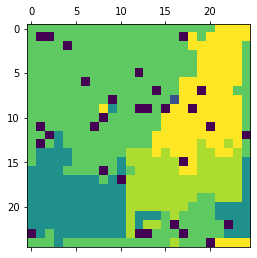

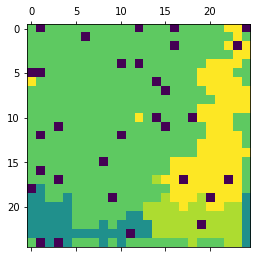

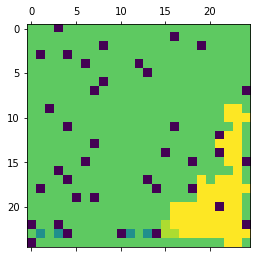

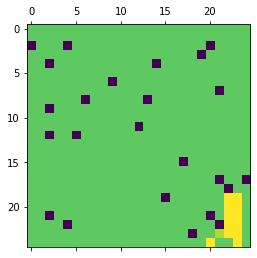

In [10]:
%matplotlib inline

model_0.run(step)
plt.matshow(model_0.trait_grid())
plt.show()

model_0.run(step)
plt.matshow(model_0.trait_grid())
plt.show()

model_0.run(step)
plt.matshow(model_0.trait_grid())
plt.show()

model_0.run(step)
plt.matshow(model_0.trait_grid())
plt.show()

### Bonus 
If we need a title image, here is a random 25x25 grid

[]

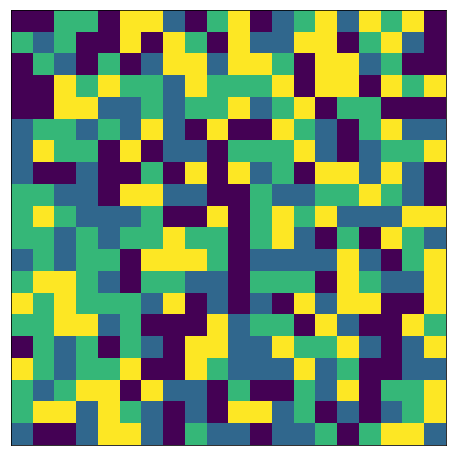

In [11]:
%matplotlib inline
n = 20
size = 8
colors = 4
fig, ax = plt.subplots(figsize=(size, size))
image = np.random.randint(colors, size=n*n).reshape((n, n))
ax.matshow(image)
ax.set_xticks([])
ax.set_yticks([])

In [12]:
cmap = plt.get_cmap('viridis', 8)
cmap(0.5)

(0.122312, 0.633153, 0.530398, 1.0)